In [49]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer, KNNImputer


##defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'rachaeld-data445'
bucket = s3.Bucket(bucket_name)

#defining the csv file
file_key = 'train_data.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

train_data = pd.read_csv(file_content_stream)
train_data.head()


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [50]:
##(5 points) Report the number of observations For each product code.
train_data['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

/tmp/ipykernel_4943/342769593.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  product_groups= train_data.groupby('product_code').mean()


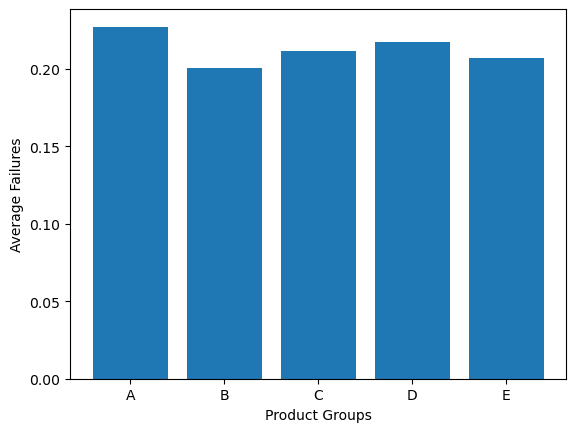

In [51]:
##(15 points) Create two visualizations that may show interesting relationships between the input
##variables and the target variable. Make sure to describe the visualizations.
product_groups= train_data.groupby('product_code').mean()
plt.bar(product_groups.index, product_groups['failure'])
plt.xlabel('Product Groups')
plt.ylabel('Average Failures')
plt.show()

The above plot shows for each producrt group the average amount of failures. So the group with the most failures is A, and in descending order goes, A-D-C-E-B, meaning B has the lowest amount of average failures. 

<AxesSubplot: xlabel='measurement_3', ylabel='Count'>

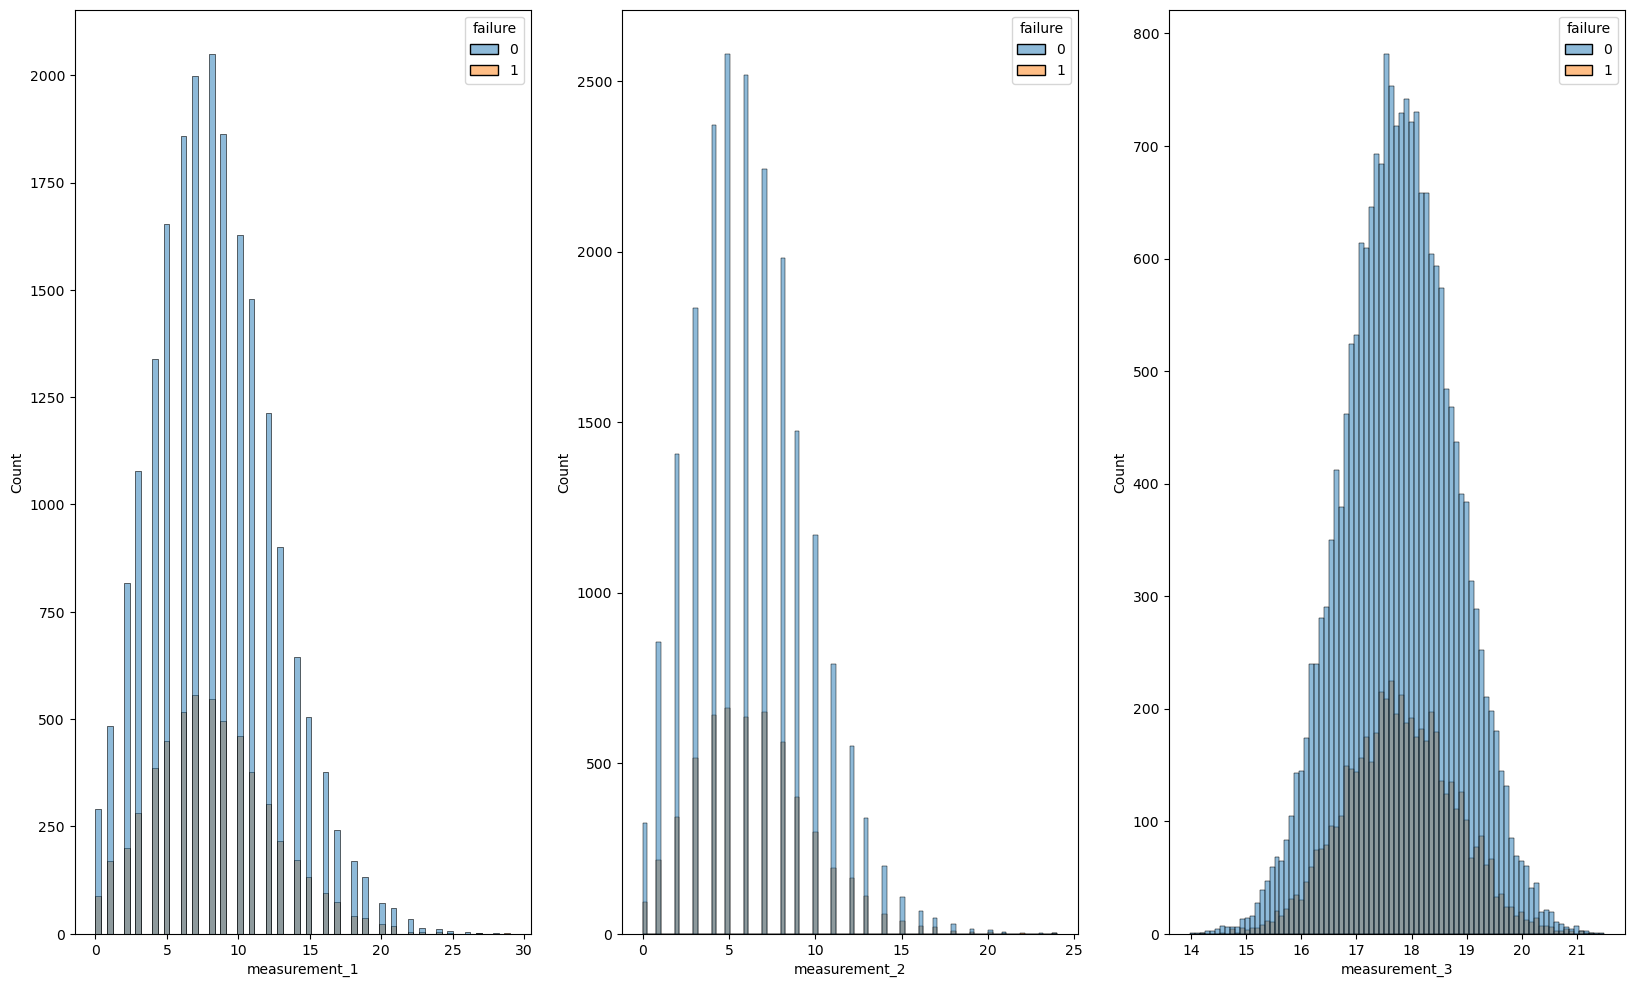

In [52]:
### MAKING ANOTHER VISUAL
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize = (20, 12))


sns.histplot(ax = axes[0], x = 'measurement_1', hue = 'failure', fill = True, data = train_data)
sns.histplot(ax = axes[1], x = 'measurement_2', hue = 'failure', fill = True, data = train_data)
sns.histplot(ax = axes[2], x = 'measurement_3', hue = 'failure', fill = True, data = train_data)


From the above plot we see the count of fails and successes at each value for the measurements. We can see that for all three the data is pretty much normal, but measurements a 1 and 2 are slightly right skewed. We can also see that There is more fails compared to successes for all three measurements. 

In [64]:
## defining inputs and target
X = train_data.drop(columns = ['failure'], axis = 1)
Y = train_data['failure']

#splitting the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)

In [65]:
X_train_i= X_train.drop(columns=['product_code', 'attribute_0', 'attribute_1'], axis=1)
X_test_i= X_test.drop(columns=['product_code', 'attribute_0', 'attribute_1'], axis=1)

In [66]:
##defining the imputer
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(X_train_i)

##imputing the missing values
X_train_imp = pd.DataFrame(imputer.transform(X_train_i), columns = X_train_i.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_i), columns = X_test_i.columns)

In [68]:
### ADABOOST ###
ADA_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier( max_depth = 5), n_estimators = 500, learning_rate = .01).fit(X_train_imp, Y_train)

##predicting on test
ADA_pred = ADA_md.predict_proba(X_test_imp)[:,1]

##ROC-AUC score
ADA_auc= roc_auc_score(Y_test, ADA_pred)

print("Area under the ROC curve:", ADA_auc)

Area under the ROC curve: 0.566710308127041


In [69]:
##Product code A imputation 
Train_code_A = X_train[X_train['product_code'] == 'A']
Y_train_code_A = Y_train.loc[X_train['product_code'] == 'A']
Test_code_A = X_test[X_test['product_code'] == 'A']
Y_test_code_A = Y_test.loc[X_test['product_code'] == 'A']

##drop columns 
Train_code_A = Train_code_A.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
Test_code_A = Test_code_A.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)

##imputing 
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(Train_code_A)

##imputing the missing values
Train_code_A = pd.DataFrame(imputer.transform(Train_code_A), columns = Train_code_A.columns).reset_index(drop = True)
Test_code_A = pd.DataFrame(imputer.transform(Test_code_A), columns = Test_code_A.columns).reset_index(drop = True)


In [70]:
##Product code B imputation 
Train_code_B = X_train[X_train['product_code'] == 'B']
Y_train_code_B = Y_train.loc[X_train['product_code'] == 'B']
Test_code_B = X_test[X_test['product_code'] == 'B']
Y_test_code_B = Y_test.loc[X_test['product_code'] == 'B']

##drop columns 
Train_code_B = Train_code_B.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
Test_code_B = Test_code_B.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)

##imputing 
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(Train_code_B)

##imputing the missing values
Train_code_B = pd.DataFrame(imputer.transform(Train_code_B), columns = Train_code_B.columns).reset_index(drop = True)
Test_code_B = pd.DataFrame(imputer.transform(Test_code_B), columns = Test_code_B.columns).reset_index(drop = True)


In [71]:
##Product code C imputation 
Train_code_C = X_train[X_train['product_code'] == 'C']
Y_train_code_C = Y_train.loc[X_train['product_code'] == 'C']
Test_code_C = X_test[X_test['product_code'] == 'C']
Y_test_code_C = Y_test.loc[X_test['product_code'] == 'C']

##drop columns 
Train_code_C = Train_code_C.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
Test_code_C = Test_code_C.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)

##imputing 
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(Train_code_C)

##imputing the missing values
Train_code_C = pd.DataFrame(imputer.transform(Train_code_C), columns = Train_code_C.columns).reset_index(drop = True)
Test_code_C = pd.DataFrame(imputer.transform(Test_code_C), columns = Test_code_C.columns).reset_index(drop = True)


In [72]:
##Product code D imputation 
Train_code_D = X_train[X_train['product_code'] == 'D']
Y_train_code_D = Y_train.loc[X_train['product_code'] == 'D']
Test_code_D = X_test[X_test['product_code'] == 'D']
Y_test_code_D = Y_test.loc[X_test['product_code'] == 'D']

##drop columns 
Train_code_D = Train_code_D.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
Test_code_D = Test_code_D.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)

##imputing 
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(Train_code_D)

##imputing the missing values
Train_code_D = pd.DataFrame(imputer.transform(Train_code_D), columns = Train_code_D.columns).reset_index(drop = True)
Test_code_D = pd.DataFrame(imputer.transform(Test_code_D), columns = Test_code_D.columns).reset_index(drop = True)


In [73]:
##Product code E imputation 
Train_code_E = X_train[X_train['product_code'] == 'E']
Y_train_code_E = Y_train.loc[X_train['product_code'] == 'E']
Test_code_E = X_test[X_test['product_code'] == 'E']
Y_test_code_E = Y_test.loc[X_test['product_code'] == 'E']

##drop columns 
Train_code_E = Train_code_E.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
Test_code_E = Test_code_E.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)

##imputing 
imputer = KNNImputer(n_neighbors = 5, weights = 'distance').fit(Train_code_E)

##imputing the missing values
Train_code_E = pd.DataFrame(imputer.transform(Train_code_E), columns = Train_code_E.columns).reset_index(drop = True)
Test_code_E = pd.DataFrame(imputer.transform(Test_code_E), columns = Test_code_E.columns).reset_index(drop = True)


In [74]:
Train_code = pd.concat([Train_code_A, Train_code_B, Train_code_C, Train_code_D, Train_code_E], axis = 0)
Train_Y = pd.concat([Y_train_code_A, Y_train_code_B, Y_train_code_C, Y_train_code_D, Y_train_code_E], axis = 0)

Test_code = pd.concat([Test_code_A, Test_code_B, Test_code_C, Test_code_D, Test_code_E], axis = 0)
Test_Y = pd.concat([Y_test_code_A, Y_test_code_B, Y_test_code_C, Y_test_code_D, Y_test_code_E], axis = 0)
print(Train_code.shape[0])
print(Train_Y.shape[0])
print(Test_code.shape[0])
print(Test_Y.shape[0])

21256
21256
5314
5314


In [75]:
### ADABOOST ###
ADA_md2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier( max_depth = 5), n_estimators = 500, learning_rate = .01).fit(Train_code, Train_Y)

##predicting on test
ADA_pred2 = ADA_md2.predict_proba(Test_code)[:,1]

##ROC-AUC score
ADA_auc2= roc_auc_score(Test_Y, ADA_pred2)

print("Area under the ROC curve:", ADA_auc2)

Area under the ROC curve: 0.5603566684715477


Based on my results above I would use the first strategy to predict failure, this is because this strategy had a slightly higher ROC-AUC score (.566 vs .560) than the second strategy, and with how close they are we want to go with the less complex model. However, they are very close in values so there is not a huge difference, so we could do other things to see if there could be more improvement, or see if running many iterations of these models creates a difference in performance. 